# Customer Segmentation with K-Means Clustering

In this project I will use an unsupervised learning method such as K-Means Clustering to group customer segments based on common characteristics.

Customer segmentation is one of the most frequent applications of unsupervised learning models and allows companies to target their users based on the profile to which they are traced.

The advantage of unsupervised learning is that it allows us to make predictions on unlabeled datasets. The downside is that it is not possible to know a priori the number of subsets under consideration; therefore, we will have to resort to special techniques to make the optimal estimation.

## Data Import and Analysis

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr

In [2]:
customers_df = pd.read_csv("Mall_Customers.csv")
customers_df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


General and statistical information regarding the dataset is given below.

In [3]:
customers_df.drop(['CustomerID'], axis = 1, inplace = True)
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [4]:
customers_df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Data Visualization

We begin by showing a barplot and a piechart in which clients are divided on the basis of their **gender**.

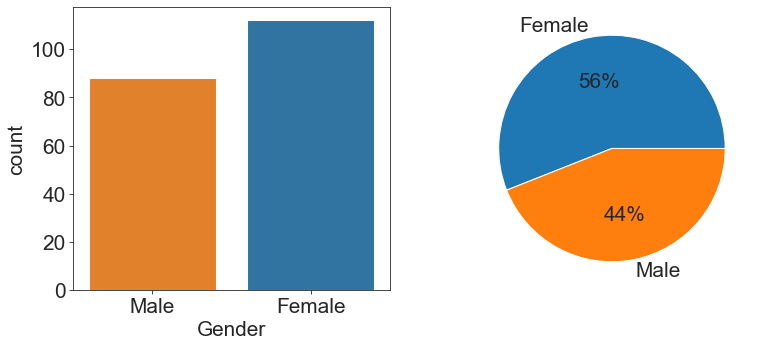

In [5]:
sns.set_style('ticks')
plt.figure(figsize=(12, 5), dpi=75)
plt.rc('font', size=20)
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=customers_df, palette=['#ff7f0e','#1f77b4'])
plt.subplot(1, 2, 2)
genders = customers_df.groupby('Gender').size()
plt.pie(genders, labels=['Female','Male'], autopct='%1.0f%%')
plt.show()

We will now proceed by visualizing the **age distribution** and the **income distribution**.

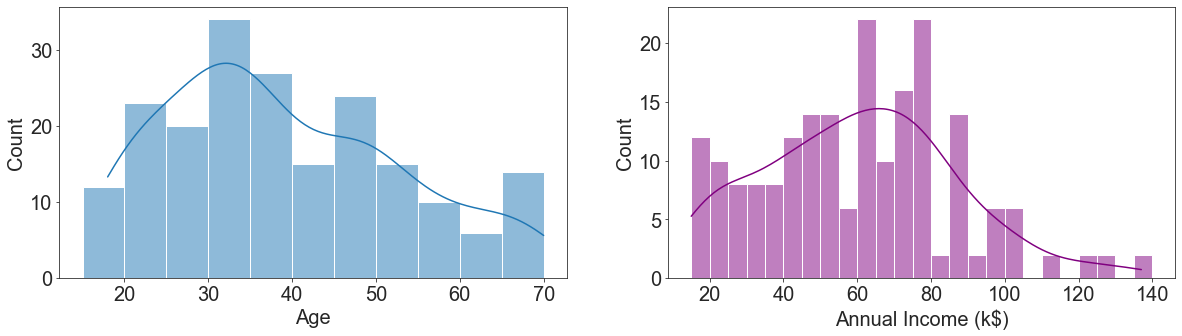

In [6]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=customers_df, x="Age", kde=True, bins=11, binrange=(15,70))
plt.subplot(1, 2, 2)
sns.histplot(data=customers_df, x="Annual Income (k$)", kde=True, color="purple", bins=25, binrange=(15,140))
plt.show()

The last aspect we consider is the **spending score**: in the histogram the genders have been divided, while in the contourplot the spending score was plotted along with the income.

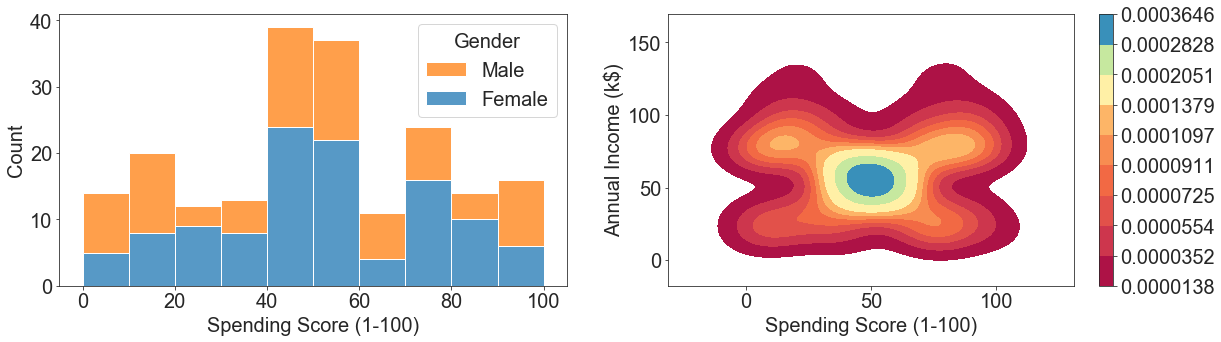

In [7]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=customers_df, x="Spending Score (1-100)", hue="Gender", palette=['#ff7f0e','#1f77b4'], multiple="stack", bins=10, binrange=(0,100))
plt.subplot(1, 2, 2)
cmap = sns.color_palette('Spectral', as_cmap=True)
sns.kdeplot(x=customers_df["Spending Score (1-100)"], y=customers_df["Annual Income (k$)"], shade=True, cbar=True, cmap=cmap)
plt.show()

From the contourplot it appears that there is no particular correlation between the annual income and the spending score.

## Data Preprocessing

Since clustering is based on dividing datasets using a distance criterion, it is necessary to convert text values into numbers using one hot encoder: genders will be converted to integers, $1$ for male, $0$ for female.

In [8]:
from sklearn.preprocessing import LabelBinarizer

LB = LabelBinarizer()
LB.fit(customers_df['Gender'])
transformed = LB.transform(customers_df['Gender'])
ohe_df = pd.DataFrame(transformed)
data = pd.concat([customers_df, ohe_df], axis=1).drop(['Gender'], axis=1)
data.rename(columns = {data.columns[3]:'Gender'}, inplace=True)

In [9]:
data.head(5)

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


## Determining Optimal Clusters

In order to proceed with a K-Means Clustering algorithm, it is necessary to determine the optimal number of groups into which we want to perform customer segmentation. Several methods exist, which will be explored below.

### Elbow Method

The idea behind this method is to vary the number $k$ of clusters, evaluate the sum of intra-cluster squared distances from the centroid $\bar{x}_j$ with $j \in \{1, ..., k\}$, and take the $k$ which corresponds to the "elbow" of the obtained graph.

In [10]:
from sklearn.cluster import KMeans

# This dictionary will contain the sum of the squared distances 
ssd = {}

for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    kmeans.fit(data)
    ssd[k] = kmeans.inertia_

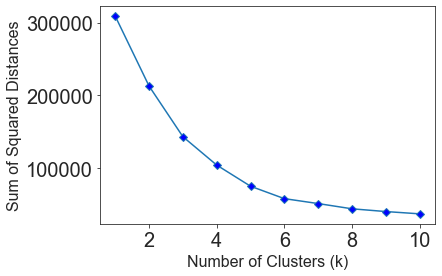

In [11]:
plt.plot(list(ssd.keys()), list(ssd.values()), marker='D', mfc='b')
plt.xlabel('Number of Clusters (k)', fontsize=16)
plt.ylabel('Sum of Squared Distances', fontsize=16)
plt.show()

Looking at the graph, it appears that the elbow point corresponds to a cluster number of 4.

### Average Silhouette Method

The silhouette method is based on calculating a silhouette coefficient that measures how similar a point is to its own cluster relative to other clusters. The silhouette coefficients for each point are then averaged to obtain the silhouette score.

The silhouette coefficient has values between $[-1, 1]$, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The coefficient for a poin $x_i$ correspond to

$$ s(x_i) = \frac{b(x_i)-a(x_i)}{\max \big( \, b(x_i)\, ,\, a(x_i) \,\big)}$$

where $a(x_i)$ is the average distance of $x_i$ with all other points in the same clusters, and $b(x_i)$ is the average distance of $x_i$ with all the points in the closest cluster to its cluster.

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k_range = [3, 4, 5, 6, 7, 8]
silhouette_avg_k = []

For k = 3 The average silhouette_score is : 0.383798873822341


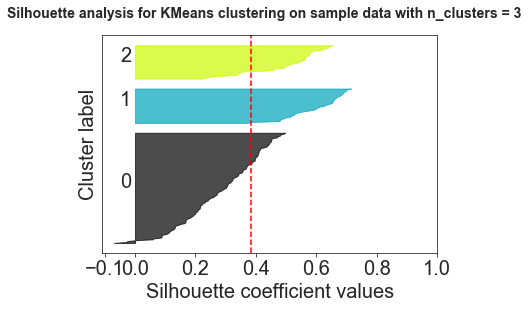

For k = 4 The average silhouette_score is : 0.4052954330641215


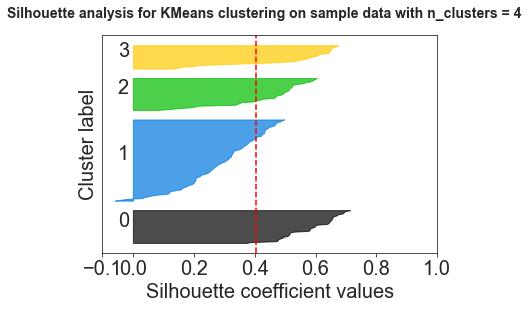

For k = 5 The average silhouette_score is : 0.44482259384548795


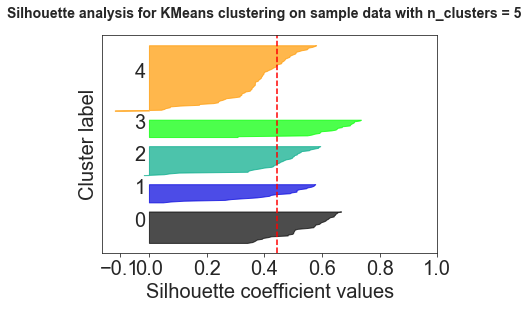

For k = 6 The average silhouette_score is : 0.45205475380756527


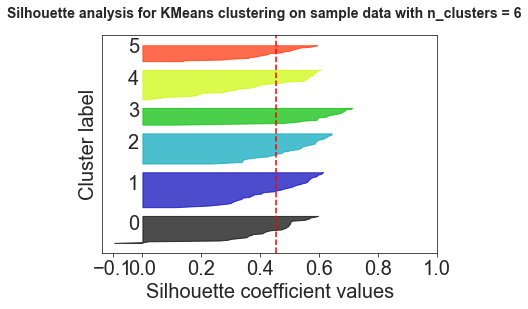

For k = 7 The average silhouette_score is : 0.44096462877395787


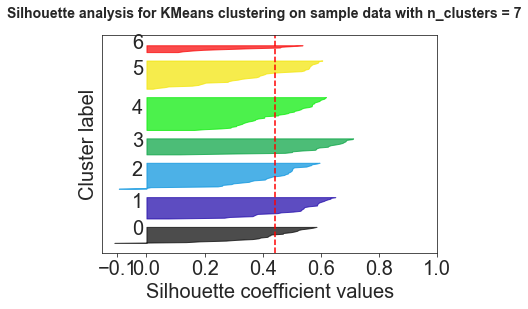

For k = 8 The average silhouette_score is : 0.4333282403082168


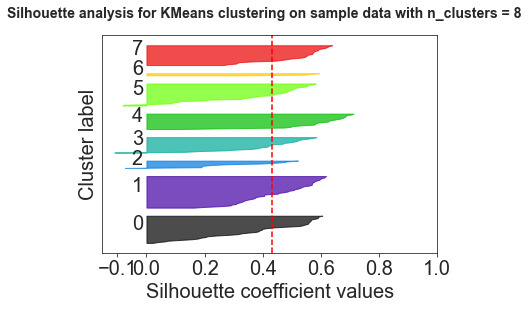

In [13]:
for k in k_range:
    kmeans = KMeans(init='k-means++', n_clusters=k)
    predictions = kmeans.fit_predict(data)

    silhouette_avg = silhouette_score(data, predictions)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_k.append(silhouette_avg)

    sample_silhouette_values = silhouette_samples(data, predictions)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[predictions == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

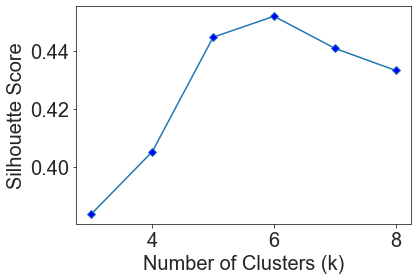

In [14]:
plt.plot(k_range, silhouette_avg_k, marker='D', mfc='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

The graph shows that the optimal number of clusters is for $k=6$. Using a second method, we were able to determine how the elbow method was misinterpreted.

### Gap Statistic Method

With this last method we can compare cluster compactness with a null reference distribution of the data, i.e. a distribution with no obvious clustering. 

A gap $k$ is calculated as

$$ G(k) = \mathbb{E} [ \log(I_k)] - \log(I_k) $$

where $I_k$ is the inertia (a measure of the squared errors) and $\mathbb{E} [\bullet]$ means average over the references distributions.

In [15]:
# The arguments of this function are: 
# data = dataframe 
# nrefs = number of sample reference datasets to create
# maxClusters = maximum number of clusters to test for

def GapStatistic(data, nrefs=3, maxClusters=10):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            # Fit to it
            kmeans = KMeans(init='k-means++', n_clusters=k)
            kmeans.fit(randomReference)
            refDisp = kmeans.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        kmeans = KMeans(init='k-means++', n_clusters=k)
        kmeans.fit(data)
        origDisp = kmeans.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

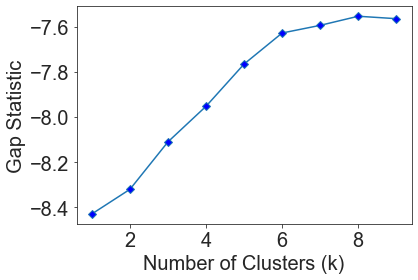

In [16]:
score_g, gap_df = GapStatistic(data, nrefs=8)
plt.plot(gap_df['clusterCount'], gap_df['gap'], marker='D', mfc='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Statistic")
plt.show()

The graph shows for $k\geq 6$ the gap measure is quite static. On the basis of our tests, we can therefore assume that the optimal value of $k$ is 6.

## Visualizing the Clustering Results

We now represent a two-dimensional visualization of the clustered data. Spending score and annual income are chosen as axes. For a 2D representation that takes all parameters into account, a PCA can be used.

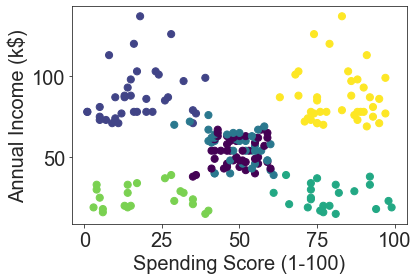

In [17]:
kmeans = KMeans(init='k-means++', n_clusters=6)
predictions = kmeans.fit_predict(data)
plt.scatter(data["Spending Score (1-100)"], data["Annual Income (k$)"], c=predictions, s=50, cmap="viridis")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Annual Income (k$)")
plt.show()

## Conclusions

The purpose of this project was to examine different techniques for optimizing the number of clusters to be used with a K-Means algorithm. After testing the Elbow Method, the Average Silhouette Method, and gap Statistic Method, I came to the conclusion that using multiple methods can be helpful in more accurately determining the optimal $k$. 

In future developments it would be interesting to consider datasets with a larger number of parameters and perform clustering after PCA.

In [18]:
sys.stderr = sys.__stderr__  # unsilence stderr